fr

In [2]:
import json
from decoding_refined import istdeco_decode
from imaging_utils import ISSDataContainer
import numpy as np
import pandas as pd
# Create the codebook
num_rounds = 5
num_channels = 5


data = json.load(open(r'..\..\ISTDECO\downloads\liver_2d\metadata.json','r'))['target_data']
codebook = np.zeros((len(data), num_rounds, num_channels))
gene_names = []
for i, item in enumerate(data):
    channels = []
    gene_names.append(item['names'])
    for r in range(num_rounds):
        for c in range(num_channels):
            codebook[i,r,c] = item[f'r{r}_c{c}']

dataset = ISSDataContainer()
dataset.add_images_from_filepattern('..\\..\\ISTDECO\\ASHLAR\\ASHLAR_R{round}_C{channel}.tif')
dataset.load()


Added ..\..\ISTDECO\ASHLAR\ASHLAR_R0_C0.tif. Stage: 0, Round: 0, Channel: 0
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R0_C1.tif. Stage: 0, Round: 0, Channel: 1
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R0_C2.tif. Stage: 0, Round: 0, Channel: 2
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R0_C3.tif. Stage: 0, Round: 0, Channel: 3
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R0_C4.tif. Stage: 0, Round: 0, Channel: 4
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R1_C0.tif. Stage: 0, Round: 1, Channel: 0
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R1_C1.tif. Stage: 0, Round: 1, Channel: 1
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R1_C2.tif. Stage: 0, Round: 1, Channel: 2
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R1_C3.tif. Stage: 0, Round: 1, Channel: 3
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R1_C4.tif. Stage: 0, Round: 1, Channel: 4
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R2_C0.tif. Stage: 0, Round: 2, Channel: 0
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R2_C1.tif. Stage: 0, Round: 2, Channel: 1
Added ..\..\ISTDECO\ASHLAR\ASHLAR_R2_C2.tif. Stage: 0, Round: 2, Channel: 2
Added ..\..\

In [95]:
from skimage.feature import peak_local_max
from scipy.ndimage import uniform_filter, gaussian_filter
from typing import Tuple


def _remove_background(image_slice, low_pass_sigmas):
    for c in range(image_slice.shape[0]):
        high_pass = image_slice[c] - gaussian_filter(image_slice[c], low_pass_sigmas)
        high_pass = np.clip(high_pass, 0.0, np.inf)
        image_slice[c] = uniform_filter(image_slice[c], size=7)
    return image_slice


def _simple_peakfinder(input: np.ndarray, min_distance, threshold_abs, threshold_rel) -> np.ndarray:
    return peak_local_max(input, min_distance, threshold_abs, threshold_rel)

def _find_peaks(image_slice, min_distance, threshold_abs, threshold_rel):
    intensities, channels, yx = [], [], []
    for c, im in enumerate(image_slice):
        yxi = _simple_peakfinder(im, min_distance, threshold_abs, threshold_rel)
        if len(yxi):
            yx.append(yxi)
            channels.append(np.full(len(yxi),c))
            intensities.append(image_slice[:, yxi[:, 0], yxi[:, 1]])
    return np.hstack(intensities).T, np.hstack(channels), np.vstack(yx)

class ChannelAnalyzer:
    """
        Class for analyzing spots in image channels.
    """
        

    def __init__(self,         
            image: np.ndarray,
            low_pass_sigmas: Tuple[int, int] = (7.0, 7.0),
            min_distance: float = 15,
            threshold_abs: float = 500,
            threshold_rel: float = 0.1,
            verbose: int = 0
        ):

        """
        Initialize a ChannelAnalyzer instance.

        Args:
            image (np.ndarray): Multichannel image data (nc x height x width).
            low_pass_sigmas (Tuple[int, int]): Standard deviations for Gaussian filtering.
            min_distance (float): Minimum number of pixels separating peaks.
            threshold_abs (float): Minimum intensity of peaks.
            threshold_rel (float): Relative threshold for peak intensity.
        """

        if image.ndim != 3:
            raise ValueError('Image must be of shape (num_channels, height, width)')
        
          

        # Remove background by subtracting a low-pass image

        if verbose:
            print('Removing background')
        image_low_pass = _remove_background(image, low_pass_sigmas)

        # Find peaks using skimages peak_local_max
        if verbose:
            print('Finding peaks')
        intensities, channels, yx = _find_peaks(
            image_low_pass, 
            min_distance, 
            threshold_abs, 
            threshold_rel
        )

        # Store in class
        self.intensities = intensities
        self.yx = yx
        self.channels = channels

        # Assign each feature to nearest channel (cosine distance)
        self.intensities_normalized = self.intensities / (np.linalg.norm(self.intensities,axis=1,keepdims=True) + 1e-5)
        self.cluster_labels = np.argmax(self.intensities_normalized, axis=1)    
        self.n_features = self.intensities.shape[1]

        # Find the center for each cluster
        self.cluster_centers = np.array(
            [
                np.mean(self.intensities[self.cluster_labels == c, :], axis=0) 
                for c in np.unique(self.cluster_labels)
            ]
        )

        # Compute scale matrix and cross talk matrices
        self.scale_matrix = np.diag(np.diag(self.cluster_centers)) 
        self.crosstalk_matrix = (np.linalg.inv(self.scale_matrix) @ self.cluster_centers).T

    def peak_finder_qc(self):
        """
        Visualize peak locations using the napari viewer.
        """
        import napari
        viewer = napari.Viewer()
        viewer.add_image(
            image_slice, 
        )
        cyx = np.hstack((self.channels.reshape((-1,1)), self.yx))
        viewer.add_points(cyx, size=2, opacity=0.5, face_color='red')
        napari.run()

    def plot_features(self):
        """
            Plot channel features using matplotlib.
        """
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(
            nrows=self.n_features, 
            ncols=self.n_features,
            figsize=(4*self.n_features,4*self.n_features),
            sharex=True,
            sharey=True
        )

        data = self.intensities
        
        for i in range(self.n_features):
            for j in range(self.n_features):
                axs[i,j].scatter(data[:, i], data[:, j], c=self.cluster_labels, cmap='viridis')
                axs[i,j].scatter(self.cluster_centers[i,i], self.cluster_centers[i, j], marker='X', s=100, c='red')
                axs[i,j].scatter(self.cluster_centers[j,i], self.cluster_centers[j, j], marker='X', s=100, c='red')


                axs[i,j].set_xlabel(f'Channel {i}')
                axs[i,j].set_ylabel(f'channel {j}')
        
        plt.tight_layout()
        plt.show()     
   

    def get_crosstalk_matrix(self):
        """
        Get the computed crosstalk matrix.

        Returns:
            np.ndarray: Crosstalk matrix.
        """
        return self.crosstalk_matrix
    def get_channel_scale_matrixx(self):
        """
        Get the computed channel scale matrix.

        Returns:
            np.ndarray: Channel scale matrix.
        """
        return self.scale_matrix

image_slice = dataset.get_loaded_images_array().squeeze()
image_slice = image_slice[0,:,512:2000,512:2000].astype('float32')
channel = ChannelAnalyzer(image_slice)

In [91]:
channel.intensities.shape

(5, 1802)

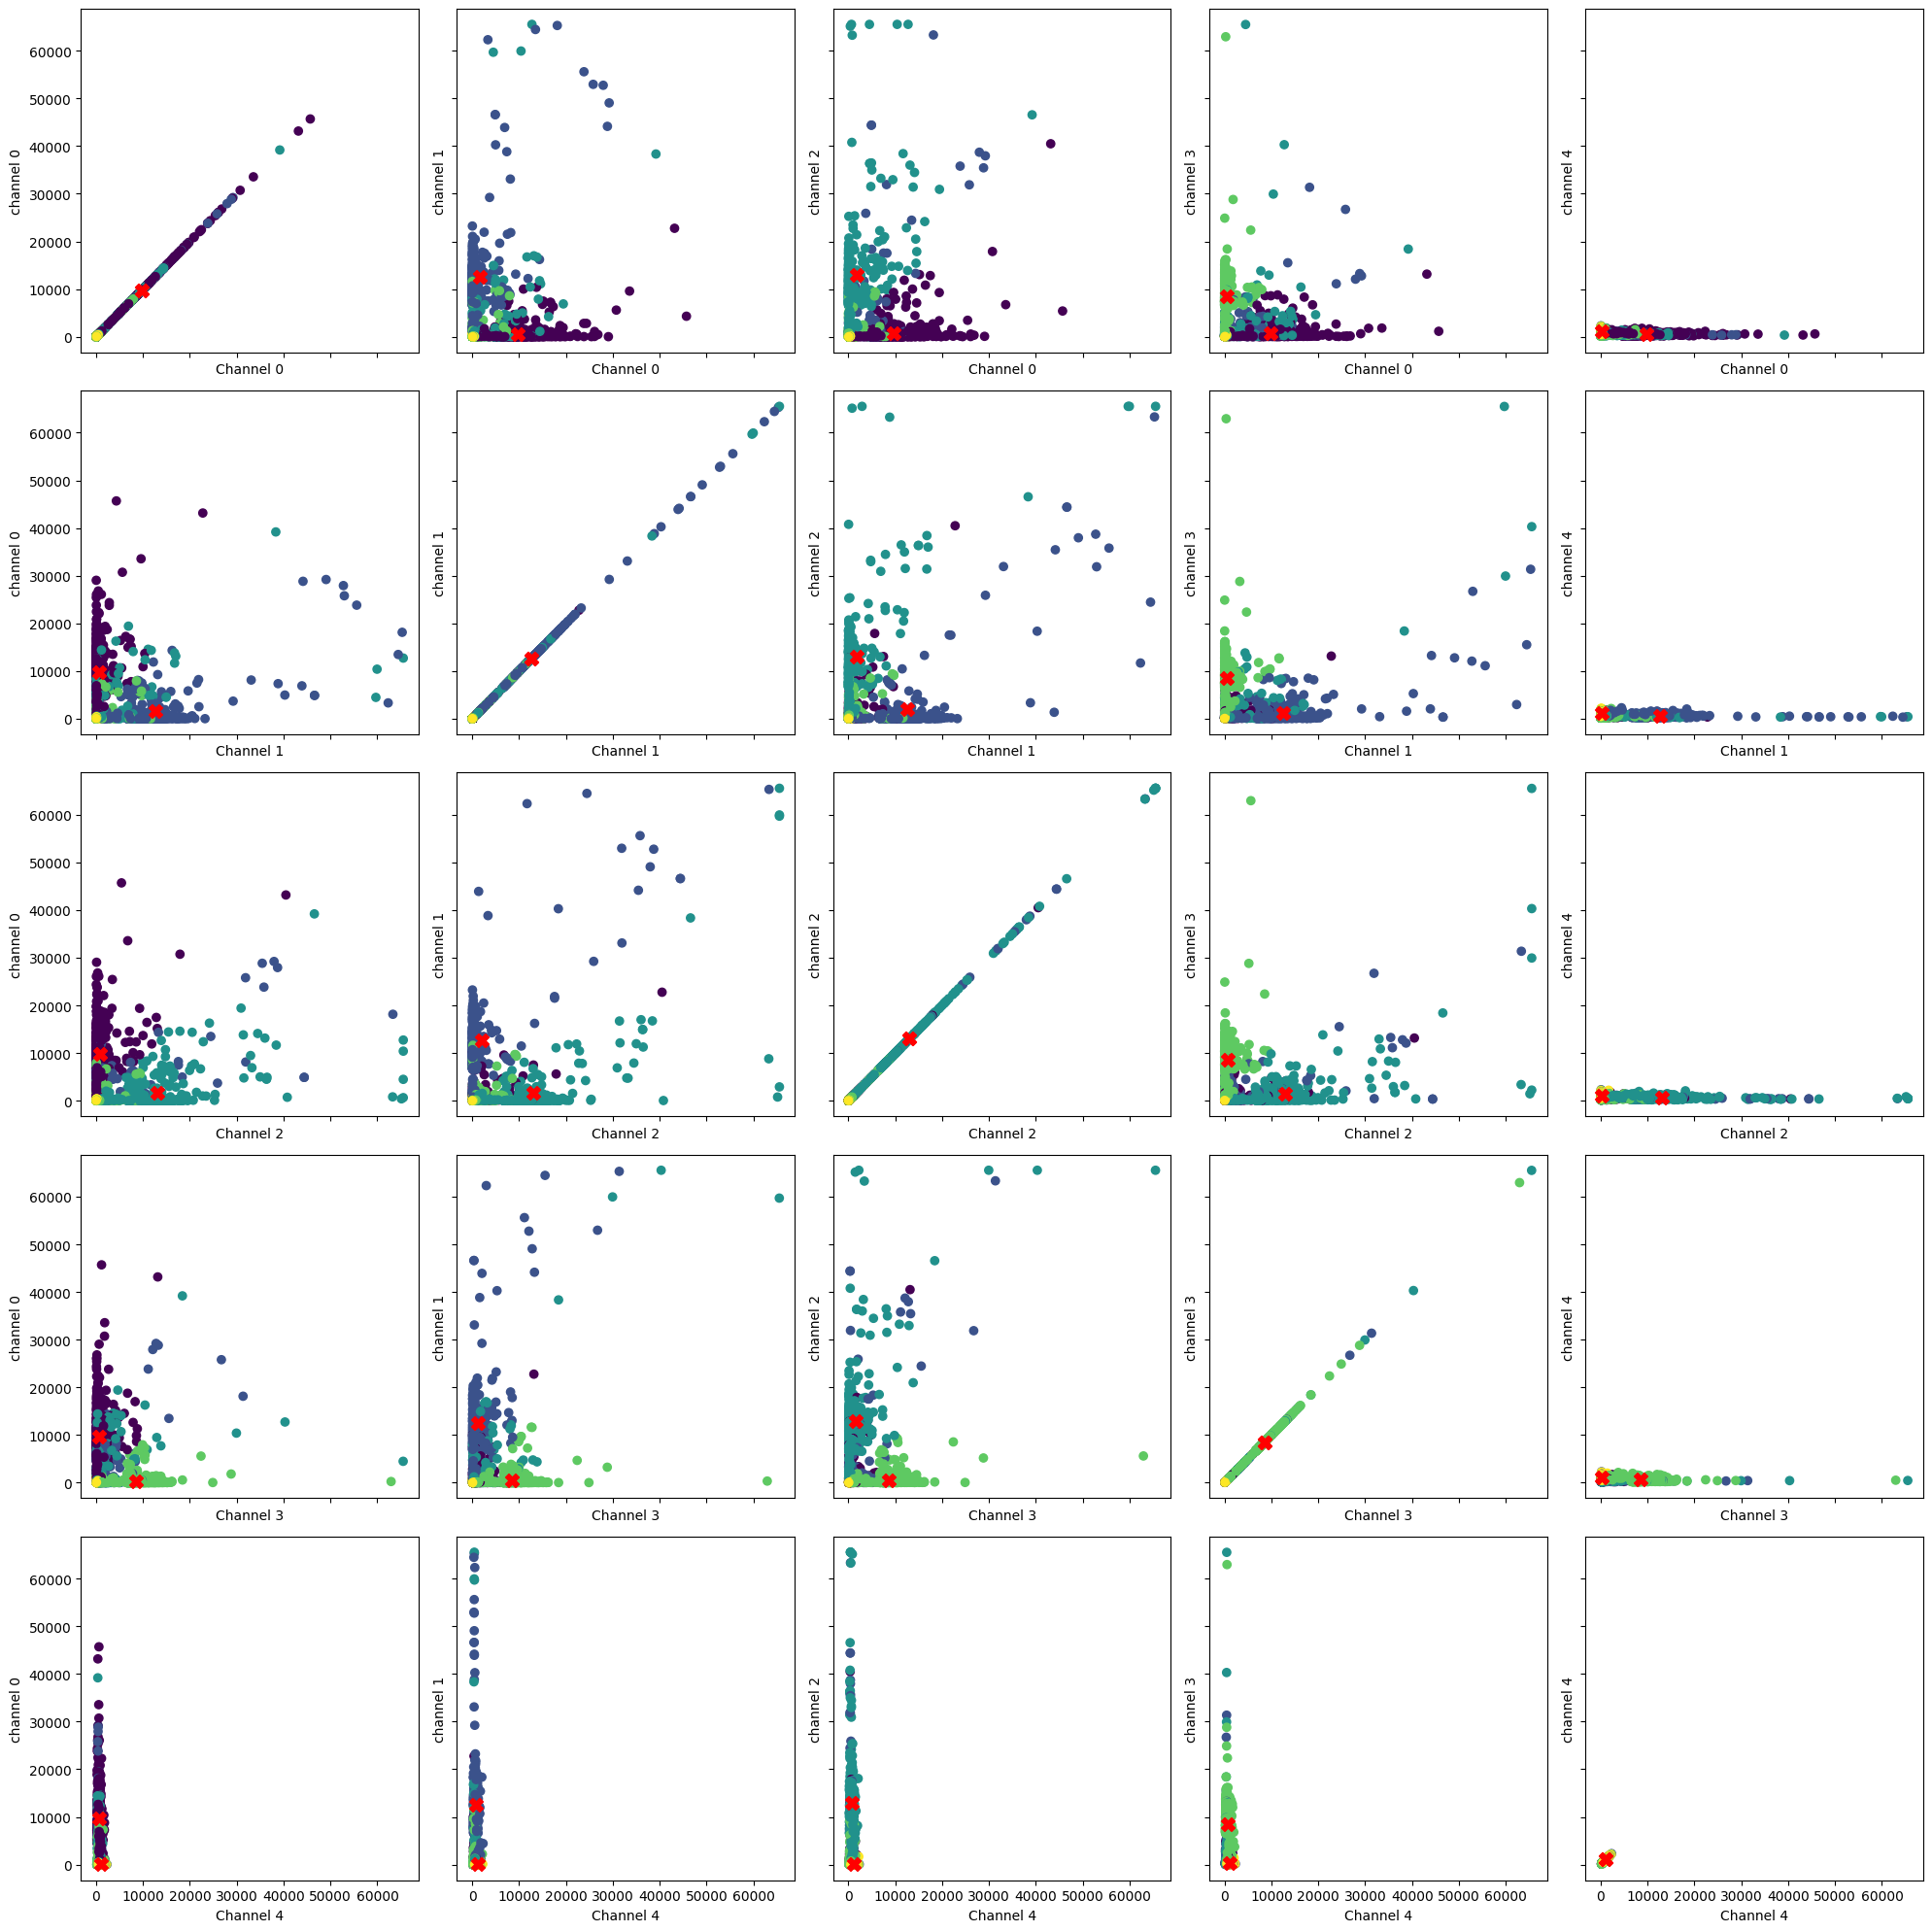

In [96]:
channel.plot_qc()

(1, 1, 5)

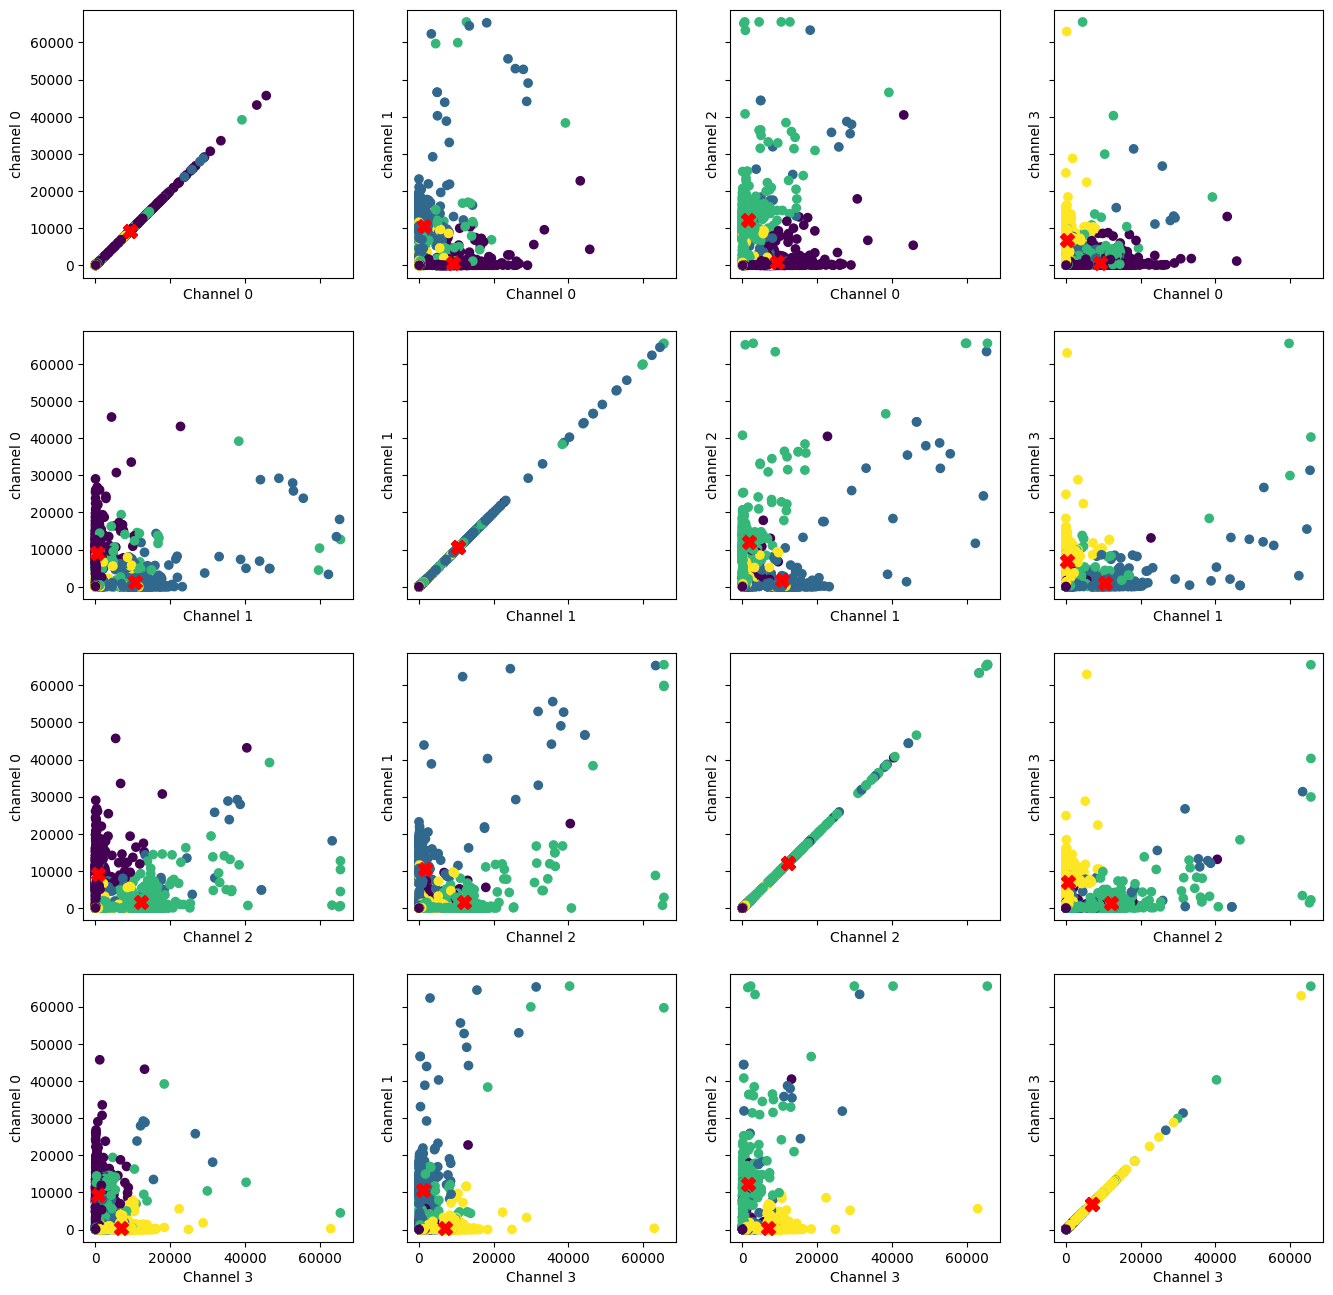

<Figure size 1600x1600 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt


    



    return scale, offset
scale, bleed = plot_scatter(intensities[:,0:4])

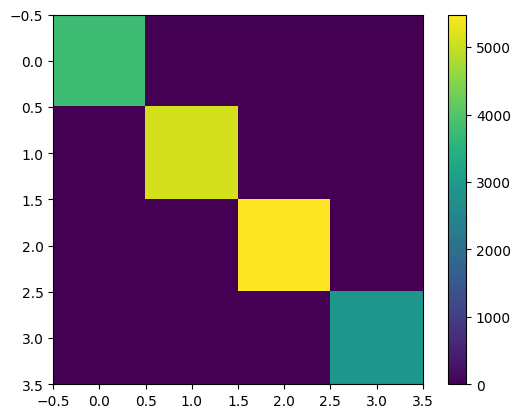

In [54]:
plt.imshow(scale)
plt.colorbar()

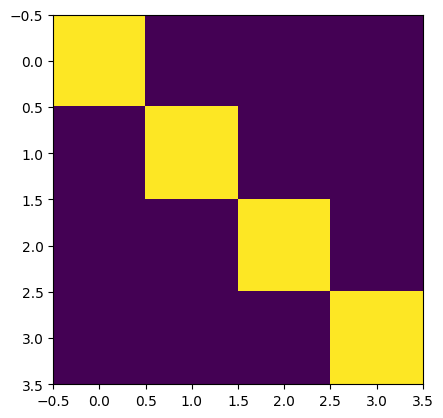

In [56]:
plt.imshow(bleed)